TABULOR MODEL FRON SCRATCH

In [1]:
%pip install torch numpy pandas fastai

Note: you may need to restart the kernel to use updated packages.


Cleaning the data

In [ ]:
import pandas as pd

df = pd.read_csv('./Titanic/train.csv')
df



In [ ]:
df.isna().sum()



In [ ]:

modes = df.mode().iloc[0]

In [ ]:
df.fillna(modes, inplace=True)

In [ ]:
import numpy as np
df.describe(include=(np.number))

In [ ]:
df['Fare'].hist()

In [ ]:
df['LogFare'] = np.log1p(df['Fare'])

In [ ]:
df['LogFare'].hist()

In [ ]:
pclasses = sorted(df.Pclass.unique())
pclasses

In [ ]:
df.describe(include='object')

In [ ]:
df = pd.get_dummies(df,columns=["Sex","Pclass","Embarked"])
df.columns

In [ ]:
import torch
from torch import tensor

t_dep = tensor(df.Survived)
added_cols= ['Sex_male','Sex_female','Pclass_1','Pclass_2','Pclass_3','Embarked_C','Embarked_Q','Embarked_S']
indep_cols = ['Age','SibSp','Parch','LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)
t_indep.shape
df[indep_cols].isna().sum()

In [ ]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.randn(n_coeff) - 0.5
coeffs * t_indep

In [ ]:
## Divise by max to normalize value
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
t_indep * coeffs

In [ ]:
preds = (t_indep * coeffs).sum(axis=1)
preds[:10]

In [ ]:
loss = torch.abs(preds - t_dep).mean()
loss

In [ ]:
def calc_preds(coeffs,indeps): return (indeps * coeffs).sum(axis=1)
def calc_loss(coeffs,indeps,dep): return torch.abs(calc_preds(coeffs,indeps) - dep).mean()

In [ ]:
coeffs.requires_grad_()

In [ ]:
loss = calc_loss(coeffs,t_indep,t_dep)
loss

In [ ]:
loss.backward()

In [ ]:
coeffs.grad

In [ ]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs,t_indep,t_dep))

In [ ]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]

In [ ]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

In [ ]:
def update_coeffs(coeffs,lr): coeffs.data.sub_(coeffs.grad * lr)

In [ ]:
def one_epoch(coeffs,lr):
    preds = calc_preds(coeffs,trn_indep)
    loss = torch.abs(preds - trn_dep).mean()
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs,lr)
    print(f"{loss:.4f}",end='; ')

In [ ]:
def init_coeffs(): return (torch.randn(n_coeff) - 0.5).requires_grad_()

In [ ]:
def train_model(epochs=30,lr=0.01):

    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs,lr)
    return coeffs

In [ ]:
coeffs = train_model(100,lr=0.02)
coeffs

In [ ]:
def shows_coeffs(): return dict(zip(indep_cols,coeffs.requires_grad_(False)))

shows_coeffs()

In [ ]:
preds = calc_preds(coeffs,val_indep)
results = val_dep.bool() == (preds > 0.5)
results[:15]

In [ ]:
results.float().mean()

In [ ]:
def acc(coeffs): return (val_dep.bool() == (calc_preds(coeffs,val_indep) > 0.5)).float().mean()
acc(coeffs)

In [ ]:
def calc_preds(coeffs,indeps): return torch.sigmoid((indeps * coeffs).sum(axis=1))

In [ ]:
coeffs = train_model(150,lr=2)

In [ ]:
acc(coeffs)

In [ ]:
tst_df = pd.read_csv('./Titanic/test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [ ]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log1p(tst_df['Fare'])
tst_df = pd.get_dummies(tst_df,columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [ ]:
tst_df['Survived'] = (calc_preds(coeffs,tst_indep) > 0.5).int()

In [ ]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('submission.csv',index=False)

In [ ]:
!head submission.csv

In [ ]:

def calc_preds(coeffs,indeps): return torch.sigmoid(indeps@coeffs)


In [ ]:
def init_coeffs(): return (torch.rand(n_coeff,1) * 0.1).requires_grad_()

trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [ ]:
val_dep.shape

In [ ]:
coeffs = train_model(1000,lr=0.1)

In [ ]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff,n_hidden) - 0.5) / n_hidden
    layer2 = torch.rand(n_hidden,1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs,indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs,lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)

In [ ]:
coeffs = train_model(lr=2)

In [ ]:
acc(coeffs)

In [ ]:
def init_coeffs():
    hiddens= [10,10]
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i],sizes[i+1])-0.3) / sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [ ]:
def calc_preds(coeffs,indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [ ]:
def update_coeffs(coeffs,lr):
    layers,conts = coeffs
    for layer in layers+conts: layer.sub_(layer.grad * lr)

In [ ]:
coeffs = train_model(lr=0.0002)

In [ ]:
acc(coeffs)

FRAMEWORK

In [ ]:
df = pd.read_csv('./Titanic/train.csv')

def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC",B="ABC",C="ABC",D="DE",E="DE",F="FG",G="FG"))

add_features(df)

In [ ]:
splits = RandomSplitter(seed=42)(df)

In [ ]:
from fastai.tabular.all import *

dls = TabularPandas(df, splits=splits,
procs=[Categorify,FillMissing,Normalize]
,cat_names=["Sex","Pclass","Embarked","Deck"]
,cont_names=["Age","SibSp","Parch","LogFare"]
,y_names="Survived",y_block=CategoryBlock()
).dataloaders(path=".")

In [ ]:
learn = tabular_learner(dls,metrics=accuracy,layers=[10,10])

learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit(16,lr=0.03)

In [ ]:
tst_df = pd.read_csv('./Titanic/test.csv')
tst_df["Fare"] = tst_df.Fare.fillna(0)
add_features(tst_df)

tst_dl = learn.dls.test_dl(tst_df)

preds,_ = learn.get_preds(dl=tst_dl)
print(preds)
tst_df['Survived'] = (preds[:,0]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('submission.csv',index=False)

In [ ]:
!tail submission.csv

In [ ]:
import torch

# create two tensors
a = torch.tensor([[1, 2,3], [3, 4,3]])
b = torch.tensor([[5, 6,3], [7, 8,3]])

# perform matrix multiplication
c = torch.matmul(a, b)
c

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# load data
data = pd.read_csv('./Titanic/train.csv')
data.isna().sum()
modes = df.mode().iloc[0]
data.fillna(modes, inplace=True)
data['Fare'] = np.log(data['Fare'] + 1)  # take the log of the Fare column
X = data.drop(['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1).values
y = data['Survived'].values

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train)
print(y_train)
# define model architecture
class TabularModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# create model
model = TabularModel(input_size=X_train.shape[1], hidden_size=64, output_size=1)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train model
for epoch in range(100):
    # convert data to PyTorch tensors
    inputs = torch.tensor(X_train.astype(np.float32))
    labels = torch.tensor(y_train.astype(np.float32))
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()

    # print statistics
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

# evaluate model
with torch.no_grad():
    # convert data to PyTorch tensors
    inputs = torch.tensor(X_test.astype(np.float32))
    labels = torch.tensor(y_test.astype(np.float32))
    
    # make predictions
    outputs = model(inputs)
    predicted = (outputs > 0).squeeze().long()
    
    # calculate accuracy
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    print('Accuracy: {:.2f}%'.format(accuracy * 100))

[[ 68.           3.          19.           0.           0.
    2.21466057]
 [773.           2.          57.           0.           0.
    2.44234704]
 [812.           3.          39.           0.           0.
    3.2248579 ]
 ...
 [557.           1.          48.           1.           0.
    3.70376807]
 [558.           1.          24.           0.           0.
    5.43164561]
 [723.           2.          34.           0.           0.
    2.63905733]]
[0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0
 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0
 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1
 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1
 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 

RANDOM FOREST / BINARY SPLIT

In [24]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [26]:
df = pd.read_csv('./Titanic/train.csv')
tst_df = pd.read_csv('./Titanic/test.csv')
modes = df.mode().iloc[0]

def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    

proc_data(df)
proc_data(tst_df)

In [38]:
cats=['Sex','Embarked']
conts=['Age','SibSp','Parch','LogFare','Pclass']
dep="Survived"

df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [28]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

Binary Splits

[Text(0.5, 1.0, 'Histogram')]

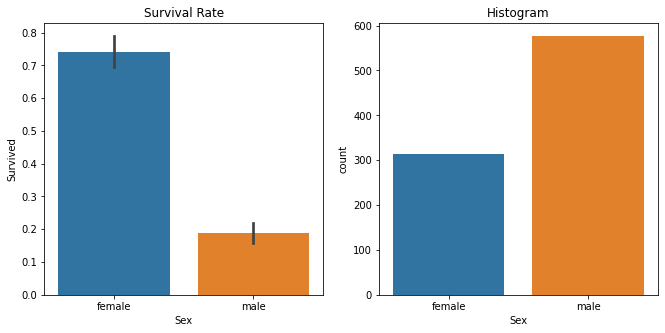

In [33]:
import seaborn as sns

fig,axs = plt.subplots(1,2,figsize=(11,5))
sns.barplot(data=df,y=dep,x="Sex",ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df,x="Sex",ax=axs[1]).set(title="Histogram")

In [44]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df,test_size=0.2)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)


In [45]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)



In [46]:
preds = val_xs.Sex == 0

In [47]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(val_y,preds)

0.21787709497206703

<AxesSubplot:xlabel='LogFare', ylabel='Density'>

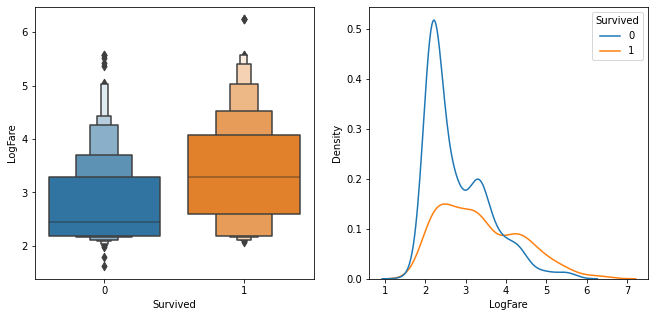

In [51]:
df_fare = trn_df[trn_df.LogFare > 0]
fig,axs= plt.subplots(1,2,figsize=(11,5))
sns.boxenplot(data=df_fare,x=dep,y="LogFare",ax=axs[0])
sns.kdeplot(data=df_fare,x="LogFare",hue=dep,ax=axs[1])

In [52]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(val_y,preds)

0.3240223463687151

In [53]:
def _side_score(side,y):
    tot= side.sum()
    if tot <= 1: return 0
    return y[side].std() * tot

In [55]:
def score(col,y,split):
    lhs = col <= split
    return (_side_score(lhs,y) + _side_score(~lhs,y)) / len(y)

In [56]:
score(trn_xs["Sex"],trn_y,0.5)
score(trn_xs["Sex"],trn_y,2.7)

0.48482397157273316

In [59]:
def iscore(nm,split):
    col = trn_xs[nm]
    return score(col,trn_y,split)

In [60]:
from ipywidgets import interact
interact(nm=conts,split=15.5)(iscore)

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

<function __main__.iscore(nm, split)>

In [61]:
interact(nm=cats,split=2)(iscore)

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

<function __main__.iscore(nm, split)>

In [62]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  ,
       22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 ,
       29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  ,
       36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  , 42.  ,
       43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  ,
       51.  , 52.  , 53.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  ,
       59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 70.  , 70.5 ,
       74.  , 80.  ])

In [63]:
scores = np.array([score(col,trn_y,o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

5.0

In [64]:
def min_col(df,nm):
    col,y=df[nm],df[dep]
    unq= col.dropna().unique()
    scores = np.array([score(col,y,o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df,"Age")

(5.0, 0.47912809551390306)

In [65]:
cols = cats + conts
{o: min_col(trn_df,o) for o in cols}

{'Sex': (0, 0.4071185316952624),
 'Embarked': (0, 0.47886783284983037),
 'Age': (5.0, 0.47912809551390306),
 'SibSp': (4, 0.47823318504095064),
 'Parch': (0, 0.48025779612275027),
 'LogFare': (2.4390808375825834, 0.46224531743487196),
 'Pclass': (2, 0.4592920418332917)}